In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tensorflow import keras
import os
import sys
from textwrap import wrap
import scipy as sp
from matplotlib import animation
from IPython.display import HTML

In [2]:
class JointDistribution:
    """
    A class that creates animations comparing two joint distributions.
    """
    def __init__(self, true_distribution, predicted_distributions, axis_lims, iteration_interval):
        """Constructor

        Args:
            true_distribution (ndarray): Bi-dimensional histogram of the true data. 
                                         IMPORTANT: If this array came from the numpy
                                         histogram2d() function, you need to pass the 
                                         transpose to this constructor
            predicted_distributions (list): List of bi-dimensional histograms to be animated. 
            axis_lims (array_like, shape (4,)): axis limits, given as (x_min, x_max, y_min, y_max).
            figsize (array_like, shape(2,)): Size of figure
            dpi (integer): Dots per inch of figure
        """

        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.iteration_interval = iteration_interval
        self.axis_lims = axis_lims
        self.true_distribution = true_distribution


        self.ax1 = self.fig.add_subplot(121)
        self.ax1.set_title("Target Joint Distribution")
        self.ax1.set_xlabel("True Reco Jet E")
        self.ax1.set_ylabel("True Reco Jet Pt")
        self.ax1.imshow(
            true_distribution,
            origin="lower",
            aspect="auto",
            extent=axis_lims,
            norm=mcolors.LogNorm(),
            cmap="Greys",
        )
        self.ax2 = self.fig.add_subplot(122)
        self.ax2.set_title("Predicted Joint Distribution")
        self.ax2.set_xlabel("Pred. Jet E")
        self.ax2.set_ylabel("Pred. Reco Jet Pt")
        self.title = self.ax2.set_title("")
        self.pred_image = self.ax2.imshow(
            [[]],
            origin="lower",
            aspect="auto",
            extent=axis_lims,
            norm=mcolors.LogNorm(),
            cmap="Greys",
        )
        self.predicted_distributions = predicted_distributions
        self.num_frames = len(predicted_distributions)


    def init(self):
        #x = np.linspace(self.axis_lims[0], self.axis_lims[1], 10)
        #self.ax2.plot(x, x, c='r', alpha=0.5)
        #self.ax1.plot(x, x, c='r', alpha=0.5)
        return self.pred_image

    def update(self, frame):
        self.pred_image.set_data([[]])
        self.pred_image = self.ax2.imshow(
            self.predicted_distributions[frame],
            origin="lower",
            aspect="auto",
            extent=self.axis_lims,
            norm=mcolors.LogNorm(),
            cmap="Greys",
        )
        #self.pred_image.set_data(self.predicted_distributions[frame])
        self.title.set_text("Predicted Joint Distribution Iteration: {}".format(frame*self.iteration_interval))
        return self.pred_image, self.title

    def make_animation(self):
        anim = animation.FuncAnimation(
            self.fig,
            self.update,
            init_func=self.init,
            frames=np.arange(self.num_frames),
            interval=500,
        )
        return anim

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
print(os.environ['CUDA_VISIBLE_DEVICES'])

In [4]:
#sys.path.append('../models/cWGAN/Run_2021-03-21_0/')
sys.path.append('../models/cWGAN/Run_2021-04-29_0/')
import cWGAN

In [5]:
save_dir = '../models/cWGAN/Run_2021-04-29_0/'
assert(os.path.isdir(save_dir))

In [81]:
gen_losses = []
with open(save_dir+'generator_losses.txt', 'r') as f:
    for _ in range(2000000):
        line = f.readline()
        begin = int(line.find(')'))
        start = int(line.find('(', begin))
        end = int(line.find(',', begin+2))
        if start > 0:
            gen_losses.append(float(line[start+1:end]))

In [82]:
filtered_gen_losses = sp.ndimage.median_filter(gen_losses, size=5000)

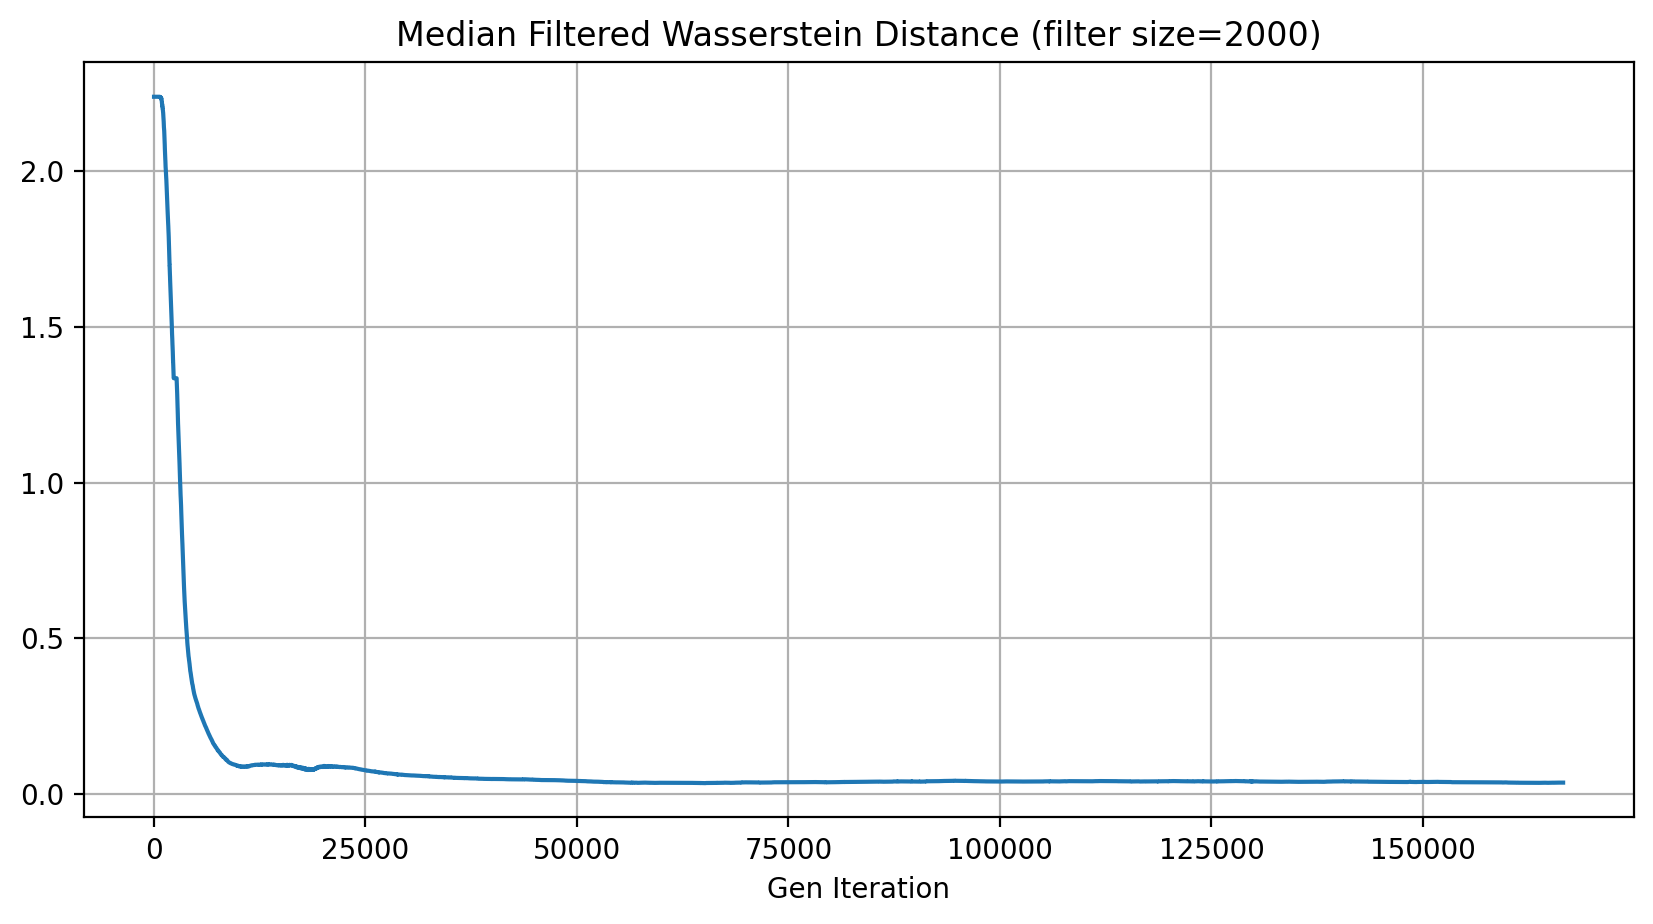

In [83]:
fig = plt.figure(figsize=(10,5),dpi=200)
ax = fig.add_subplot(111)
ax.plot(filtered_gen_losses)
ax.set_xlabel("Gen Iteration")
ax.set_title("Median Filtered Wasserstein Distance (filter size=2000)")
ax.grid()
plt.show()

In [6]:
data = np.loadtxt("../data/processed/newPartonMatchedJetsNoRecoPtCutP3Feature.txt", skiprows=2)

In [7]:
normalized_data = np.zeros((len(data), 5))
reco_data = np.zeros((len(data), 5))

# for log scaling
np.log10(data[:, 0], out=normalized_data[:, 0])
np.log10(data[:, 3], out=normalized_data[:, 3])
np.log10(data[:, 4], out=normalized_data[:, 4])
np.log10(data[:, 5], out=reco_data[:, 0])
np.log10(data[:, 8], out=reco_data[:, 3])
np.log10(data[:, 9], out=reco_data[:, 4])

normalized_data[:, 1:3] = data[:, 1:3]
reco_data[:, 1:3] = data[:, 6:8]

normalized_mean = np.mean(normalized_data, axis=0)
normalized_std = np.std(normalized_data, axis=0)
reco_mean = np.mean(reco_data, axis=0)
reco_std = np.std(reco_data, axis=0)

normalized_data = (normalized_data - normalized_mean) / normalized_std

In [8]:
cwgan = cWGAN.cWGAN(10, "RMSprop", 0.000002, 0.00001, 10, False, "", 0)

In [15]:
cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_435000')

In [16]:
%%time
predict = np.array(cwgan.make_generator_predictions(normalized_data))

CPU times: user 1min 7s, sys: 7.25 s, total: 1min 14s
Wall time: 3.07 s


In [17]:
predict = predict * reco_std + reco_mean
predict[:, 0] = 10**predict[:, 0]
predict[:, 3] = 10**predict[:, 3]
predict[:, 4] = 10**predict[:, 4]

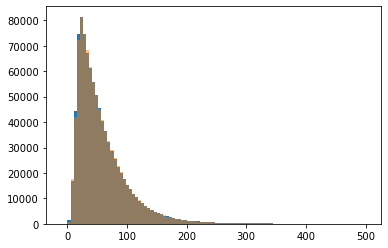

-0.00010000000000331966


In [18]:
bins = np.linspace(-10, 500, 100)
plt.hist(predict[:, 0], bins=bins)
plt.hist(data[:, 5], bins=bins, alpha=0.5)
#plt.xlim(0, 1000)
plt.show()
print(np.min(data[:, 8] - data[:, 9]))

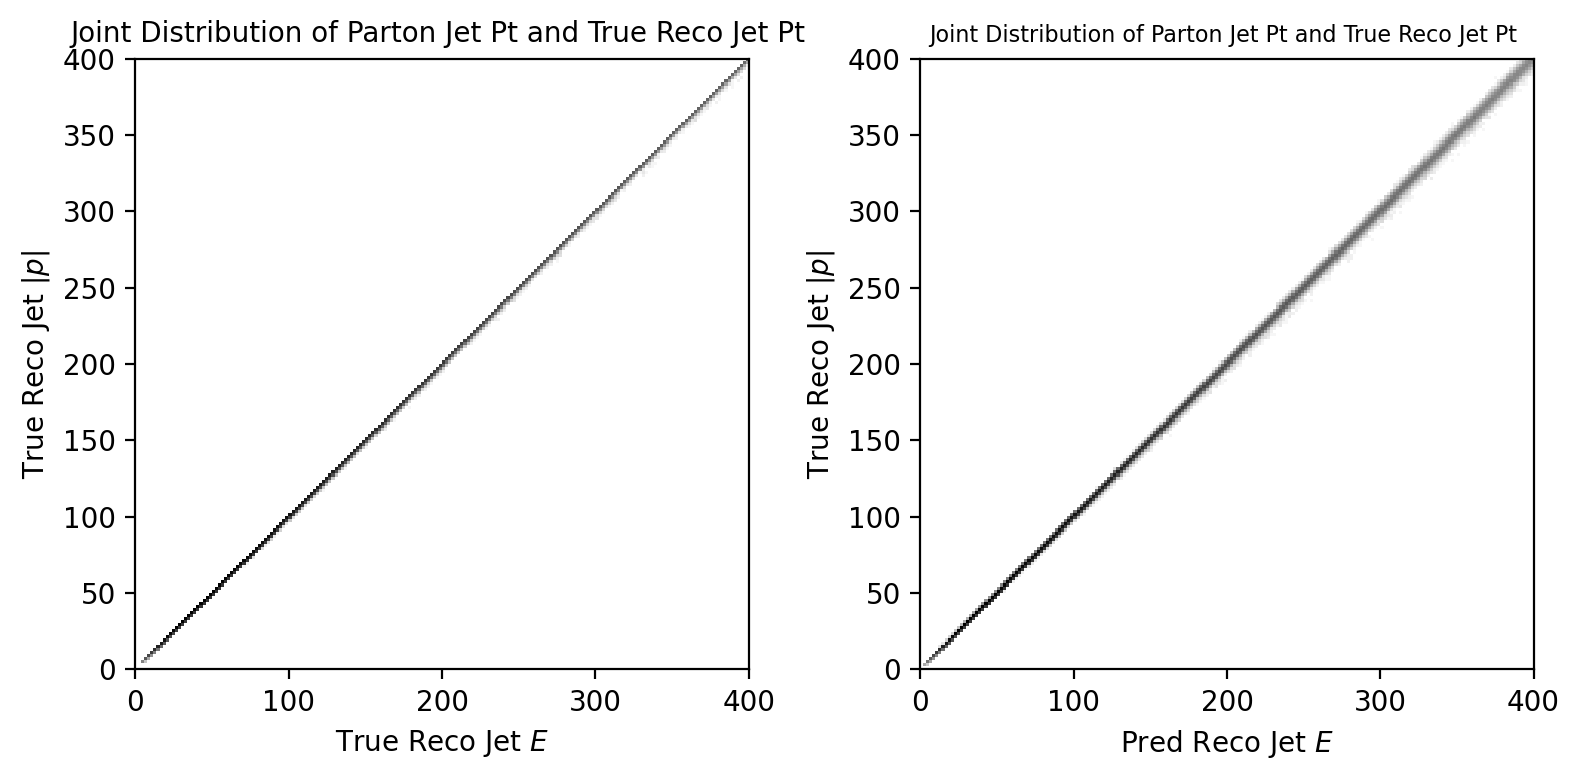

In [19]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 0
x_hi = 400
y_low = 0
y_hi = 400
num_bins=200


h2, xbins, ybins = np.histogram2d(data[:, 8], data[:, 9], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $E$")
ax1.set_ylabel(r"True Reco Jet $|p|$")
ax1.set_title("Joint Distribution of Parton Jet Pt and True Reco Jet Pt ", size=10)



z2, xbins, ybins = np.histogram2d(predict[:, 3], predict[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred Reco Jet $E$")
ax2.set_ylabel(r"True Reco Jet $|p|$")
ax2.set_title("Joint Distribution of Parton Jet Pt and True Reco Jet Pt ", size=8)
#ax2.set_xlim(0, 200)
#ax2.set_ylim(-50, 200)

# plot y=x line to make comparison easier
x = np.linspace(x_low, x_hi, 10)
#ax1.plot(x, x, c='r', alpha=0.5)
#ax2.plot(x, x, c='r', alpha=0.5)

plt.tight_layout()
plt.show()
#plt.savefig(save_dir + '/JointPtDistributions.png')

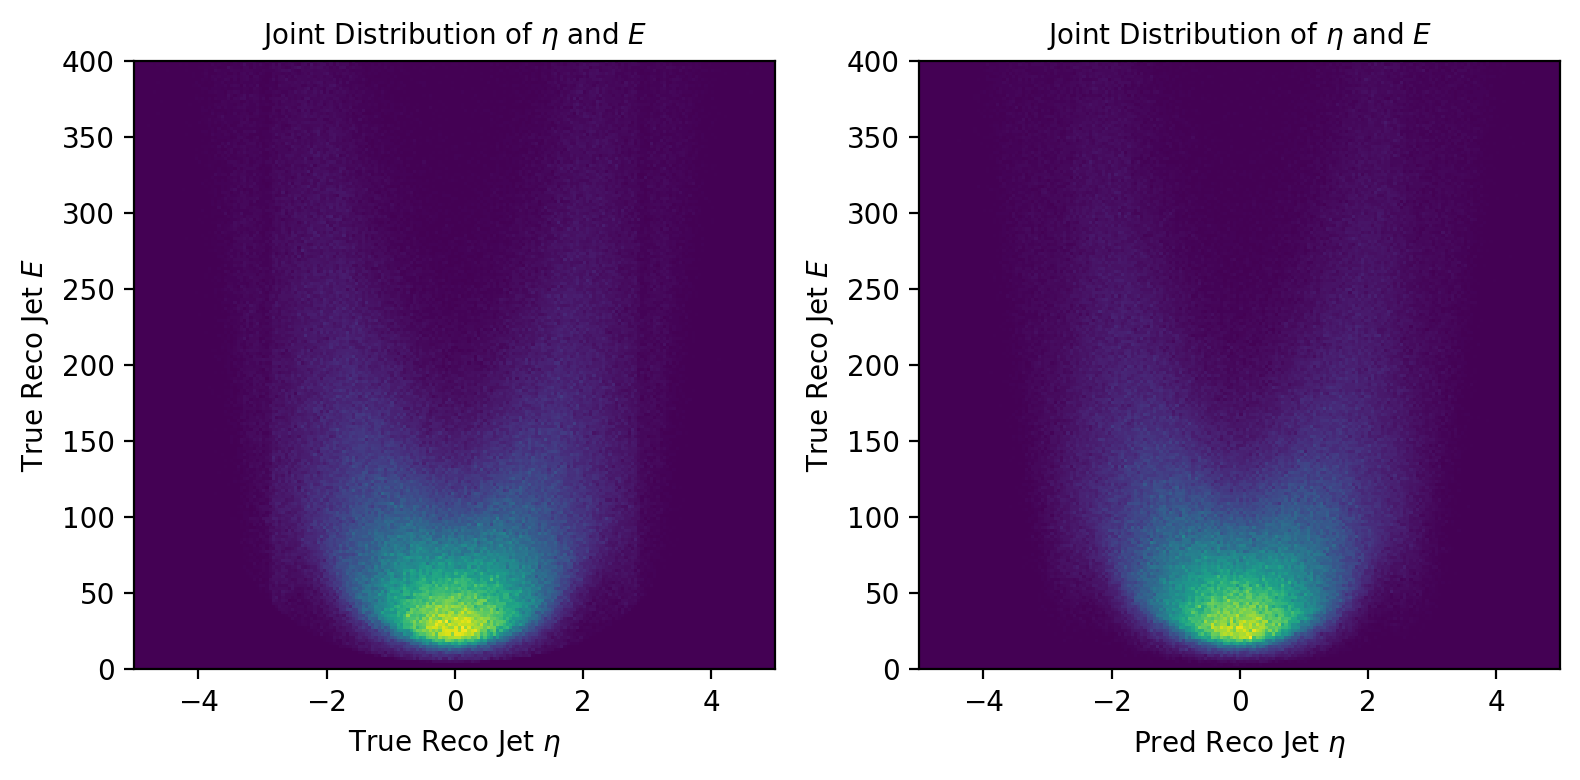

In [77]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -5
x_hi = 5
y_low = 0
y_hi = 400
num_bins=200


h2, xbins, ybins = np.histogram2d(data[:, 6], data[:,8], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\eta$")
ax1.set_ylabel(r"True Reco Jet $E$")
ax1.set_title(r"Joint Distribution of $\eta$ and $E$", size=10)



z2, xbins, ybins = np.histogram2d(predict[:, 1], predict[:, 3], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred Reco Jet $\eta$")
ax2.set_ylabel(r"True Reco Jet $E$")
ax2.set_title(r"Joint Distribution of $\eta$ and $E$", size=10)
#ax2.set_xlim(0, 200)
#ax2.set_ylim(-50, 200)

# plot y=x line to make comparison easier
x = np.linspace(x_low, x_hi, 10)
#ax1.plot(x, x, c='r', alpha=0.5)
#ax2.plot(x, x, c='r', alpha=0.5)

plt.tight_layout()
plt.show()

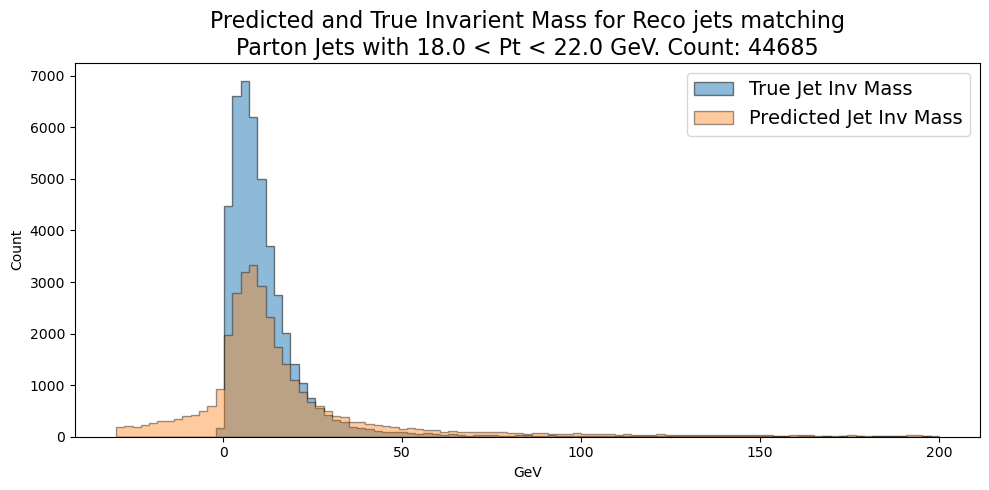

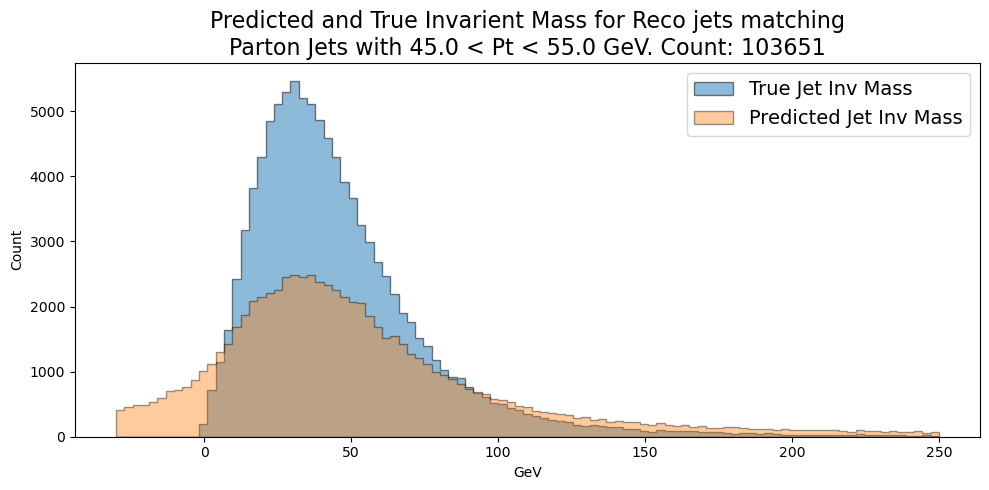

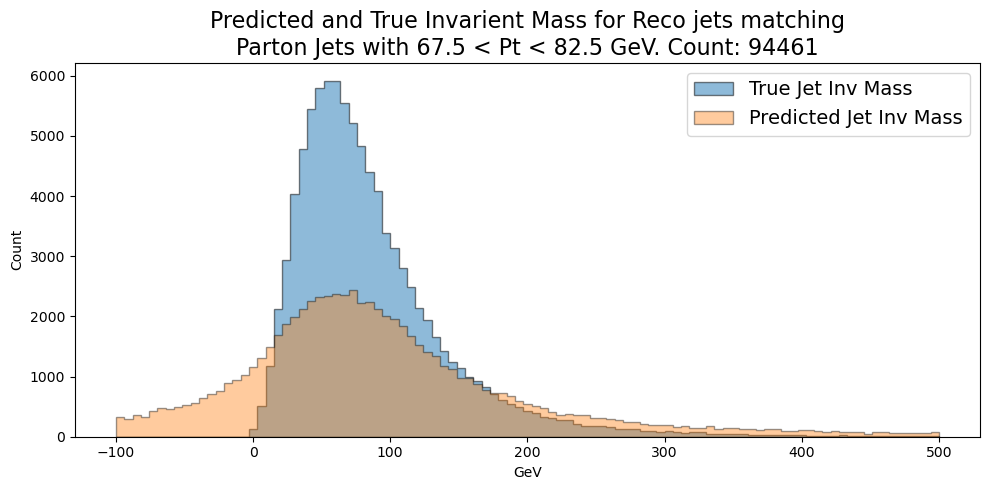

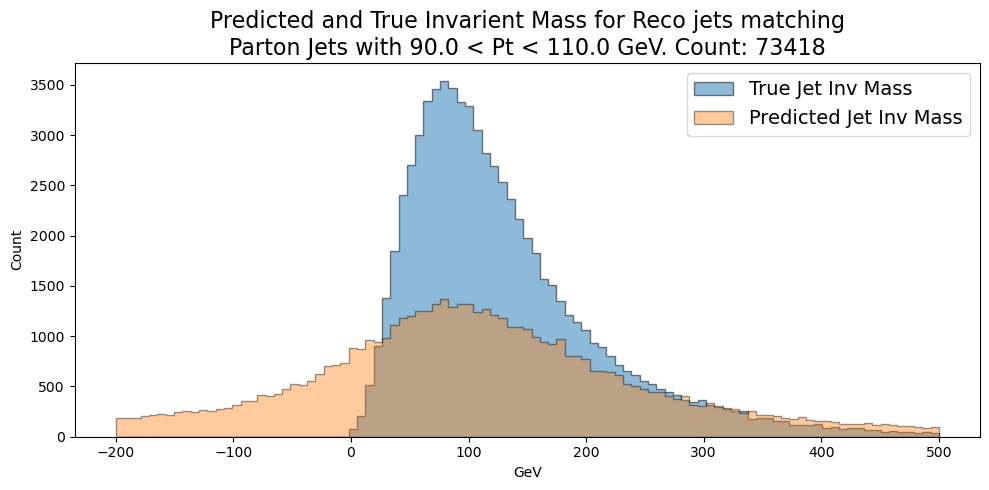

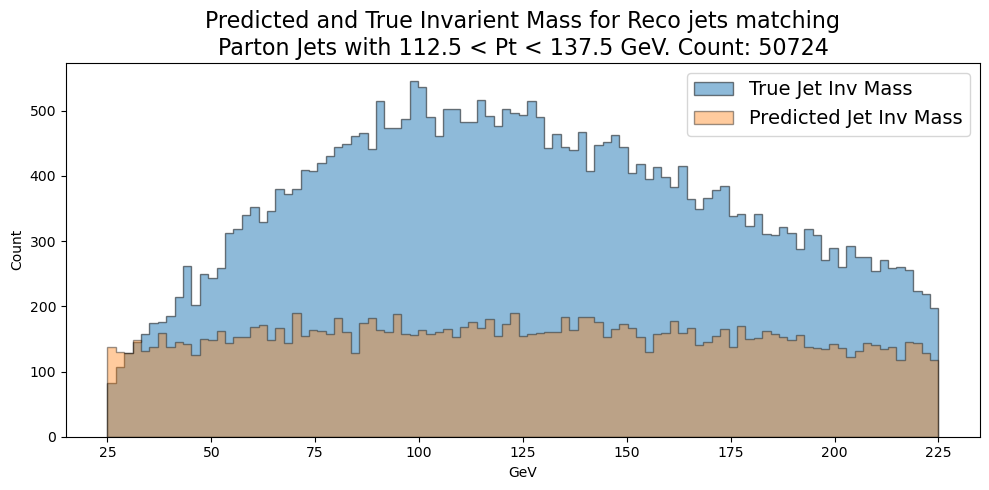

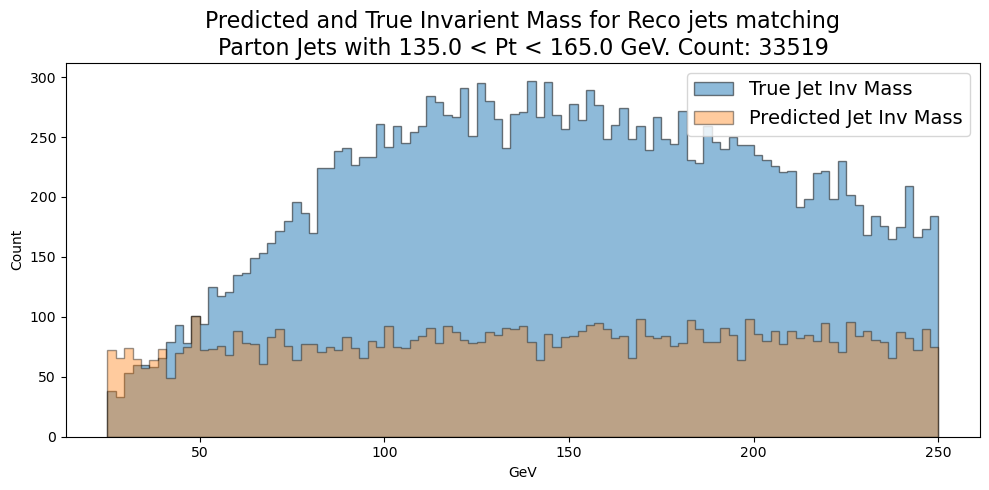

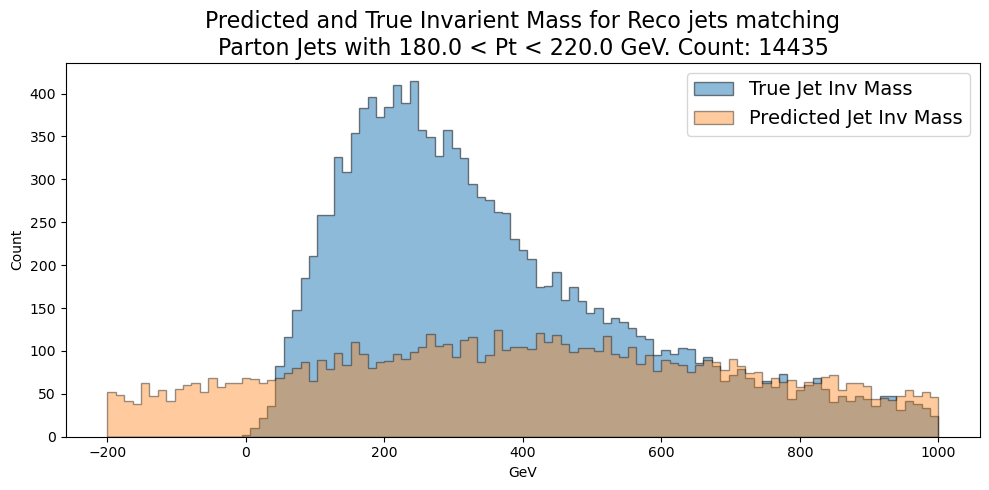

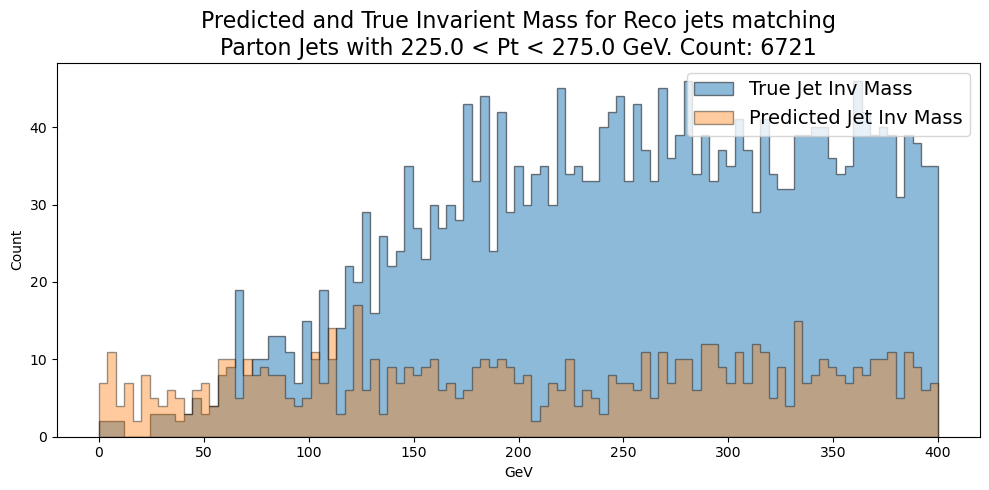

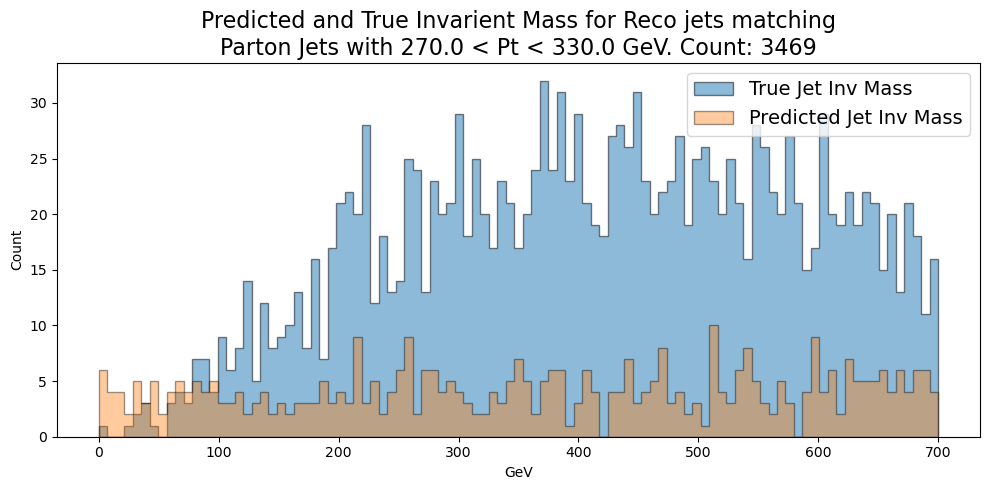

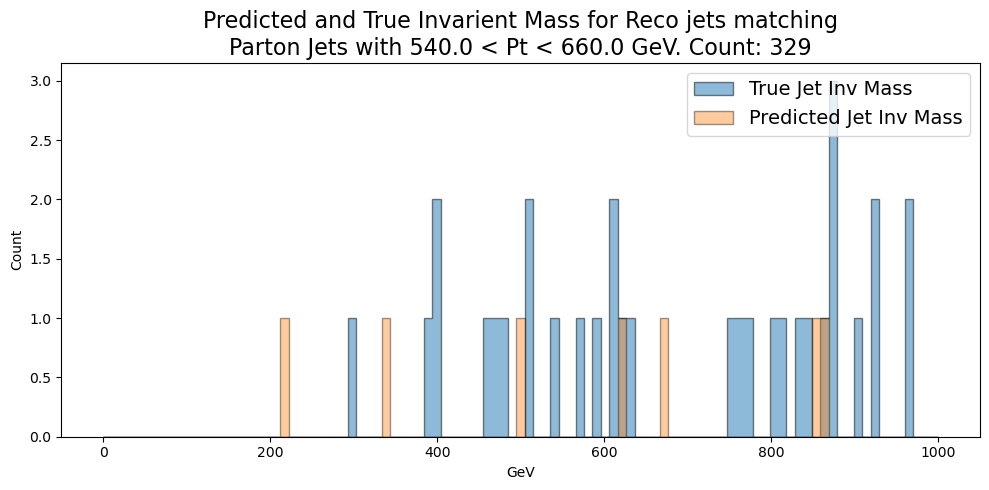

In [20]:
range_highs = [200, 250, 500, 500, 225, 250, 1000, 400, 700, 1000]
range_lows = [-30, -30, -100, -200, 25, 25, -200, 0, 0, 0]
j = 0
for center in [20, 50, 75, 100, 125, 150, 200, 250, 300, 600]:        
    recoPt = []
    predPt = []
    low = center - center/10
    high = center + center/10
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            recoPt.append(data[i, 8]**2 - data[i, 9]**2)
            predPt.append(predict[i, 3]**2 - predict[i, 4]**2)
            #recoPt.append(data[i, 5])
            #predPt.append(predict[i, 0])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(recoPt, bins=bins, label='True Jet Inv Mass', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(predPt, bins=bins, label='Predicted Jet Inv Mass', alpha=0.4, ec="k", histtype='stepfilled')
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap("Predicted and True Invarient Mass for Reco jets matching Parton Jets with {} < Pt < {} GeV. Count: {}".format(low, high, len(recoPt)), width=60)), fontsize=16)
    #ax.axvline(x=center/2)

    ax.legend(fontsize=14)
    plt.tight_layout()
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig(save_dir+"/PtDistLog{}.png".format(j), facecolor="white", transparent="True")
    j+=1

In [25]:
joint_distributions = []
x_low = 0
x_hi = 400
y_low = 0
y_hi = 400
num_bins=200
for i in range(150):
    iteration = str(i*5000)
    if i % 10 == 0: 
        print(iteration)
    cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_' + iteration)
    predict = np.array(cwgan.make_generator_predictions(normalized_data))
    predict = predict * reco_std + reco_mean
    predict[:, 0] = 10**predict[:, 0]
    predict[:, 3] = 10**predict[:, 3]
    predict[:, 4] = 10**predict[:, 4]
    
    z2, xbins, ybins = np.histogram2d(predict[:, 3], predict[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
    joint_distributions.append(z2.T)

0
50000
100000
150000
200000
250000
300000
350000
400000


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ../models/cWGAN/Run_2021-04-29_0//training_checkpoints/gen_420000

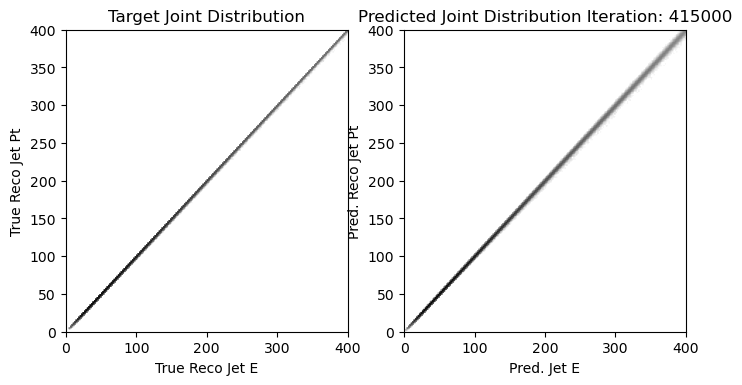

In [26]:
h2, xbins, ybins = np.histogram2d(data[:, 8], data[:, 9], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
jd = JointDistribution(h2.T, joint_distributions, (0, 400, 0, 400), 5000)
anim = jd.make_animation()
HTML(anim.to_jshtml())

In [27]:
writer = animation.PillowWriter(fps=2) 
anim.save(save_dir + 'ptvsE.gif', writer=writer)